In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.rcParams['figure.figsize'] = [16, 8]

In [2]:
df = pd.read_csv('../data/ee_joined.csv')
mp = pd.read_csv('../data/mp_joined.csv')

## Merging big wall cliffs to MP data

Running a merging operation to join the two dataframes. Earth Engine could not handle this calculation.

In [3]:
df['mp_counts'] = 0
df['num_rock_routes'] = 0
df['num_views'] = 0
df['distance_to_mp'] = None

for i, row in tqdm(df.iterrows(), total=df.shape[0]):
    filtered = mp[mp.custom_index == row.custom_index]
    mp_count = filtered.shape[0]
    if mp_count:
        df.at[i, 'mp_counts'] = mp_count
        df.at[i, 'num_rock_routes'] = filtered.num_rock_routes.sum()
        df.at[i, 'num_views'] = filtered.num_views.sum()
        df.at[i, 'distance_to_mp'] = filtered.distance_to_mp.mean()

100%|██████████| 72920/72920 [01:27<00:00, 833.10it/s] 


Now everything we need is inside the `df` dataframe. Dropping some left-over columns from Earth Engine and stuff we don't need.

In [4]:
df.drop(columns=['system:index', 'centroid', '.geo', 'custom_index', 'vicinity_mp_areas'], inplace=True)
df.columns

Index(['B2', 'B4', 'B42', 'B5', 'B6', 'B65', 'B67', 'B7', 'centroid_lith',
       'geology_alluvium', 'geology_carbonate', 'geology_colluvial_sediment',
       'geology_glacial_till_coarse', 'geology_non_carbonate',
       'geology_silicic_residual', 'height', 'latitude', 'longitude',
       'pixel_count', 'population_within_100km', 'population_within_30km',
       'population_within_60km', 'road_within_1000m', 'road_within_1500m',
       'road_within_2000m', 'road_within_500m', 'vicinity_num_rock_routes',
       'vicinity_num_views', 'mp_counts', 'num_rock_routes', 'num_views',
       'distance_to_mp'],
      dtype='object')

## Exploring association between Earth Engine-generated cliffs and MP data

Checking out the cliffs with associated MP areas. Many MP areas have their geo-tags well aligned with the location of the cliff according to earth engine.

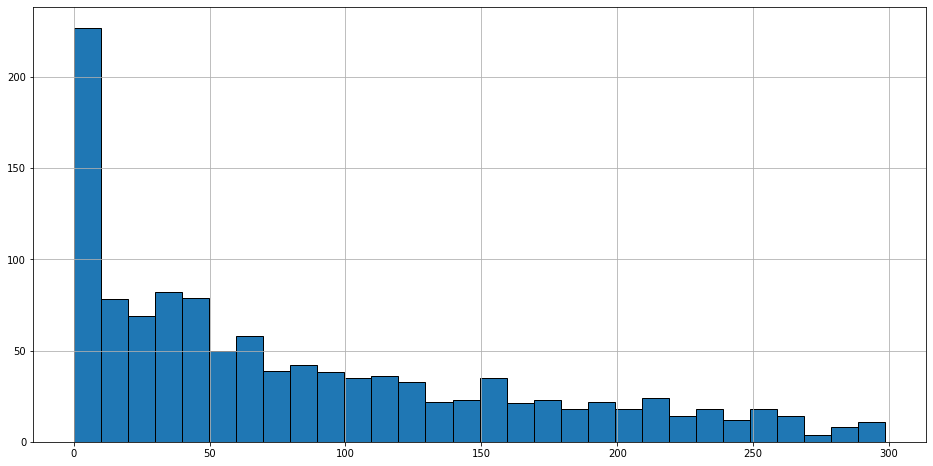

In [5]:
df.distance_to_mp.hist(bins=30, edgecolor='black', linewidth=1.0);

Most cliffs have no associated MP areas. Some have many.

In [6]:
for n in range(20):
    print((df.mp_counts == n).sum())

71749
920
147
48
23
10
9
6
2
2
2
0
1
0
1
0
0
0
0
0


Are big walls viewed more on MP? Not really...

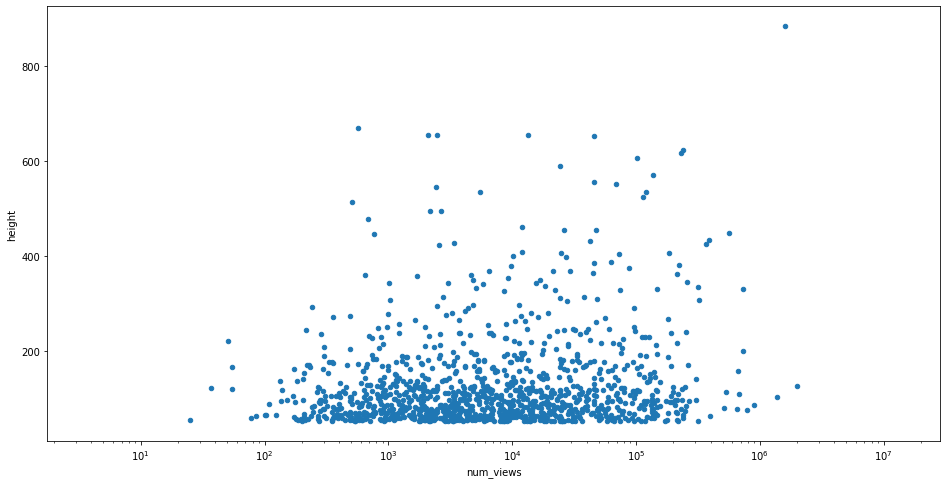

In [7]:
df[df.num_views > 0].plot(x='num_views', y='height', kind='scatter', logx=True);

But, as expected, big wall MP areas with more routes do get more views.

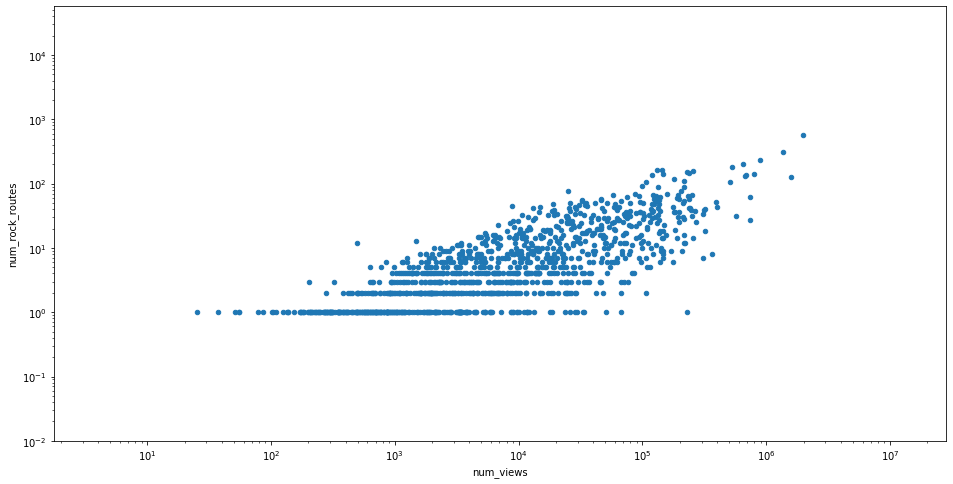

In [8]:
df[df.num_views > 0].plot(x='num_views', y='num_rock_routes', kind='scatter', loglog=True);

Cliffs for which MP geo tag doesn't align well with cliff location according to Earth Engine elevation data. These can be cross-referenced with the script in `ee_code_editor/explore_unmerged_data.js`. Some of these are aligned with actual cliffs; others are not.

In [9]:
df[df.distance_to_mp > 200][['latitude', 'longitude', 'height', 'num_rock_routes', 'distance_to_mp']].head(20)

,latitude,longitude,height,num_rock_routes,distance_to_mp
190,37.379063,-110.744756,62,1,216.44
605,48.100232,-116.430333,144,3,200.611
695,36.067025,-112.144964,262,8,206.853
1826,36.267883,-115.669406,53,13,225.29
2817,44.107454,-113.776238,57,1,255.167
2928,36.269743,-115.672725,57,10,237.987
3652,36.271371,-115.675030,60,7,232.971
4504,34.858725,-111.730046,64,7,219.471
4723,43.956727,-113.446157,65,2,216.603
7678,36.201540,-115.416154,85,1,236.738


## Accessible cliffs

Eventually, we'll partition the data into two classes -- those that are accessible (and hence explored), and those that are inaccessible. Checking out possible partitions below.

In [10]:
print((df.num_views > 1000).sum())
print((df.vicinity_num_views > 5000).sum())
print(((df.road_within_500m == 1) & (df.population_within_30km > 10_000)).sum())
print(((df.road_within_1000m == 1) & (df.population_within_60km > 100_000)).sum())
print(((df.road_within_1500m == 1) & (df.population_within_100km > 1_000_000)).sum())
print(((df.road_within_2000m == 1) & (df.population_within_100km > 2_000_000)).sum())

961
3125
2059
2706
2155
1653


In [11]:
accessible = (df.num_views > 1000) | (df.vicinity_num_views > 5000) | \
            ((df.road_within_500m == 1) & (df.population_within_30km > 10_000)) | \
            ((df.road_within_1000m == 1) & (df.population_within_60km > 100_000)) | \
            ((df.road_within_1500m == 1) & (df.population_within_100km > 1_000_000)) | \
            ((df.road_within_2000m == 1) & (df.population_within_100km > 2_000_000))

print(f'Number of accessibles: {accessible.sum()}')
print(f'Number of positives: {(df.num_views > 1000).sum()}')

Number of accessibles: 7555
Number of positives: 961


This is somewhat bad news -- we have a fairly small training set, and the training set is unbalanced. Still, smaller is better than nothing.

## Noise in the data

There are "holes" in the elevation dataset found at 'USGS/NED'. These holes give the appearance of deep wells within the elevation data. They form regions in which the elevation at several pixels is much lower than all of the surrounding elevation, and hence give "false positives". Manually removing these holds after studying the plot of height vs pixel_count. This removes roughly 1000 data points. Points above the red line are removed.

In [12]:
df[df.height > 500].sort_values(by='height', ascending=False)[
      ['height', 'latitude', 'longitude', 'pixel_count', 'num_rock_routes']].head(20)

,height,latitude,longitude,pixel_count,num_rock_routes
55944,1517,38.914940,-105.447284,21,0
58555,1281,38.694518,-114.250813,129,0
652,1243,35.680132,-118.371031,69,0
64977,1141,41.125676,-105.999867,6,0
64976,1141,41.125766,-106.000017,1,0
64975,1141,41.125010,-106.000602,147,0
64978,1141,41.124774,-105.999837,23,0
52768,884,37.731722,-119.635903,2448,125
52424,880,48.971787,-121.002191,206,0
52425,880,48.975689,-120.995760,701,0


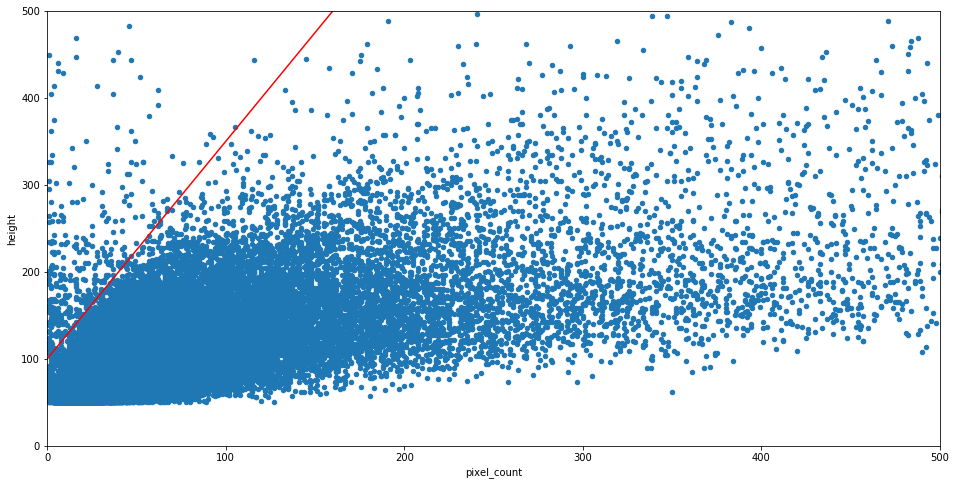

Number of data points removed: 6004


In [13]:
df.plot(x='pixel_count', y='height', kind='scatter', xlim=(0, 500), ylim=(0, 500))
line = lambda x: 2.5 * x + 100
plt.plot([0, 1000], [line(0), line(1000)], 'k-', color='red')
plt.show()
mask = (df.height < 2.5 * df.pixel_count + 100) & (df.pixel_count > 10)
print(f'Number of data points removed: {(~mask).sum()}')
df = df[mask]

Other bits of noise exist in the data. Removing a few landsat bands with negative values.

In [14]:
mask = (df.B2 > 0) & (df.B4 > 0) & (df.B5 > 0) & (df.B6 > 0) & (df.B7 > 0)
print(f'Number of data points removed: {(~mask).sum()}')
df = df[mask]

Number of data points removed: 27


## Other trends

Now we visualize possible correlations among data values. ML models will flesh these out.

Possible lithology values: [ 0  1  3  4  5  7  8 10 11 13 14 16 17 18 19]


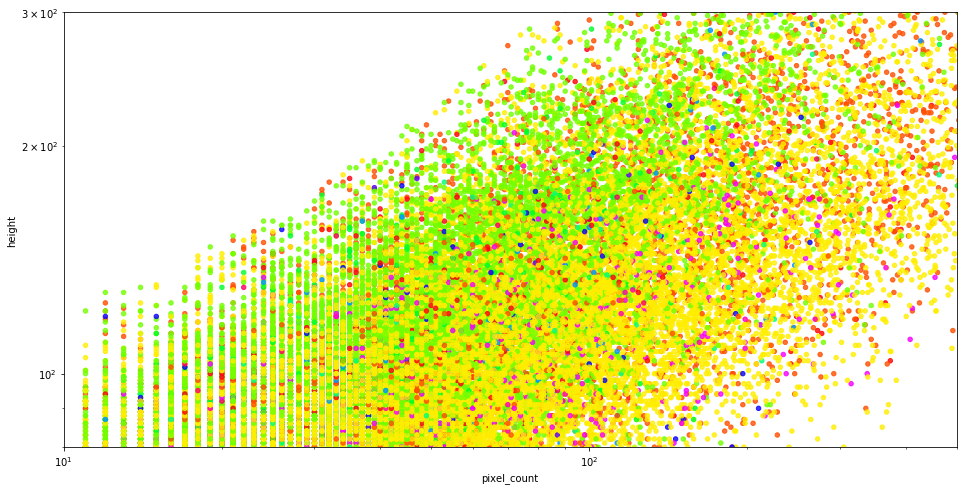

In [15]:
print(f'Possible lithology values: {df.centroid_lith.unique()}')
cmap = plt.cm.get_cmap('hsv', 20)
df.plot(x='pixel_count', y='height', c=df.centroid_lith.apply(lambda x: cmap(x)),
        alpha=0.8, kind='scatter', xlim=(10, 500), ylim=(80, 300), loglog=True);

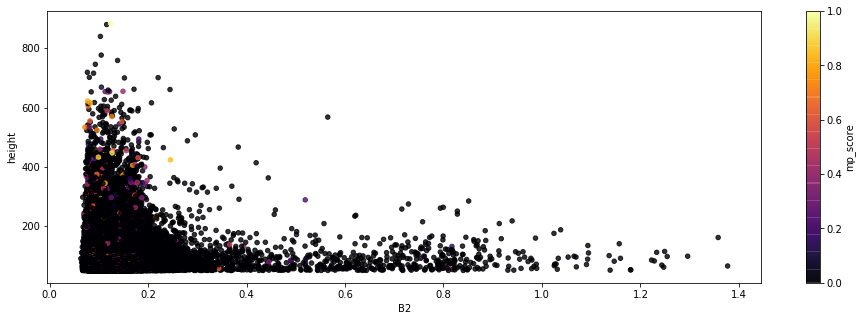

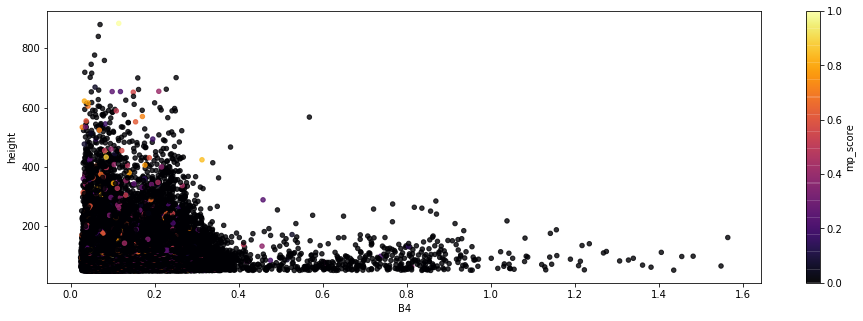

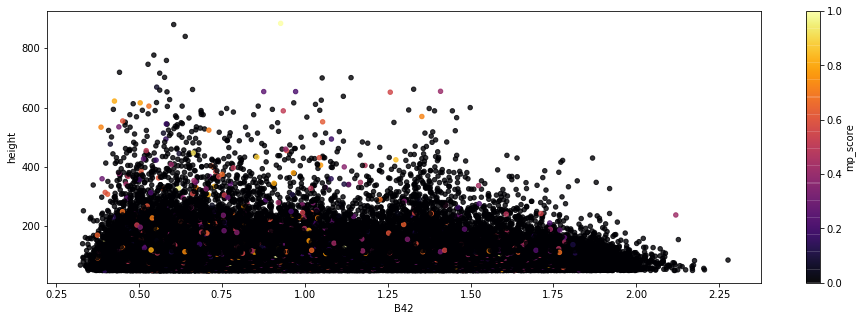

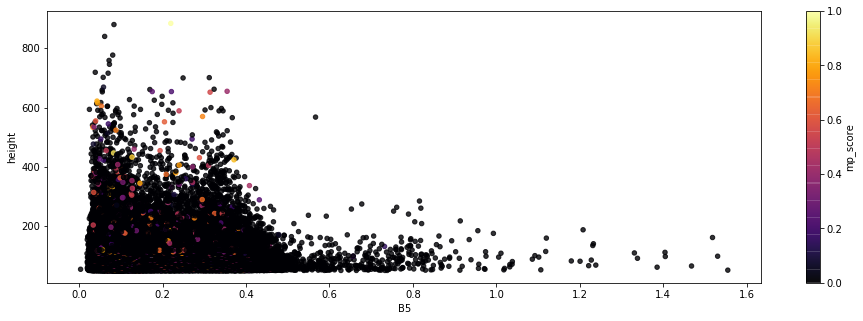

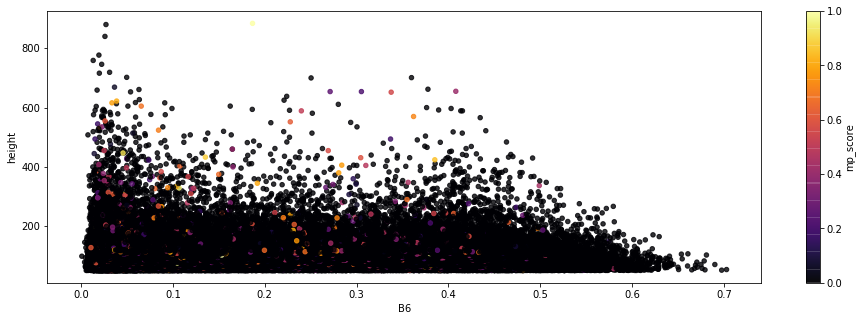

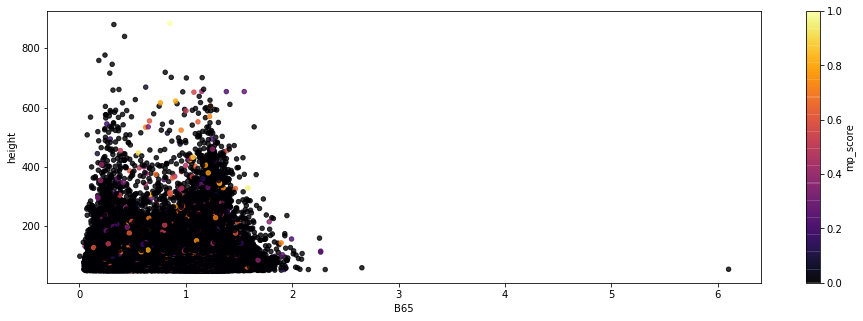

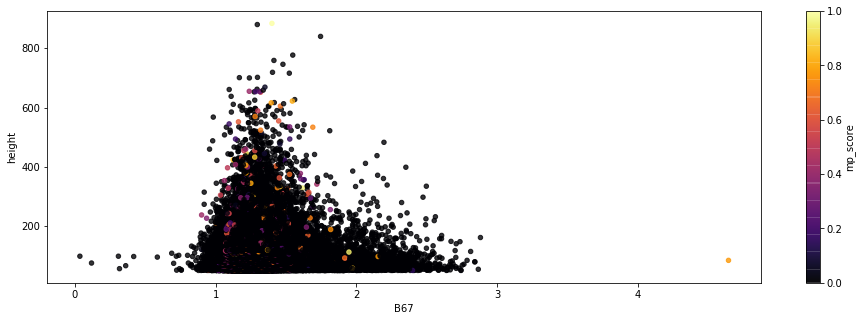

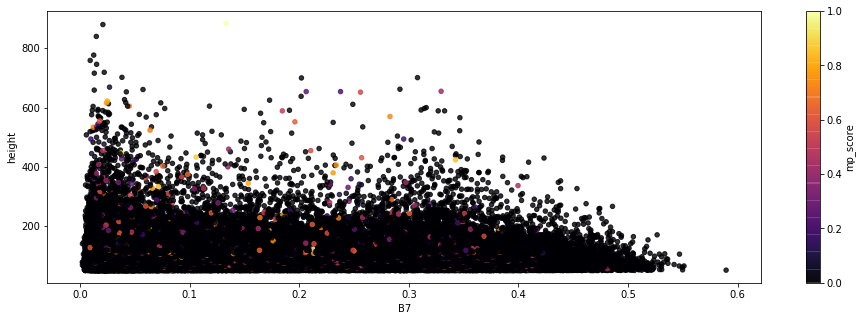

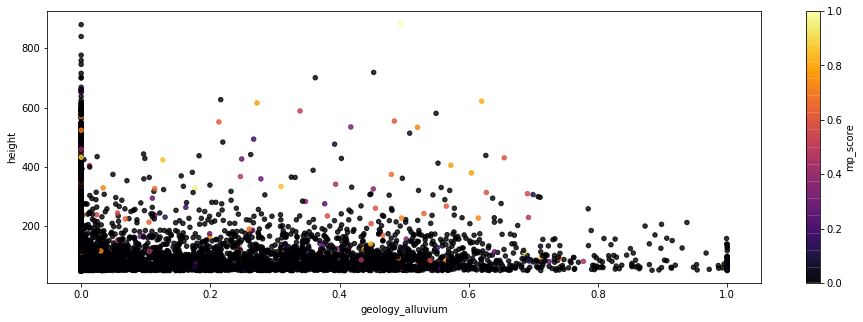

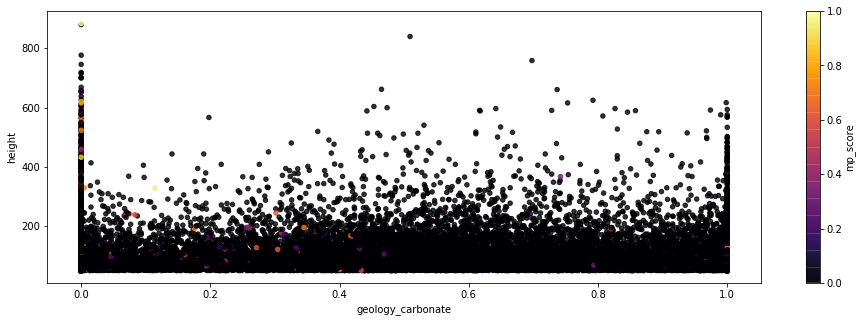

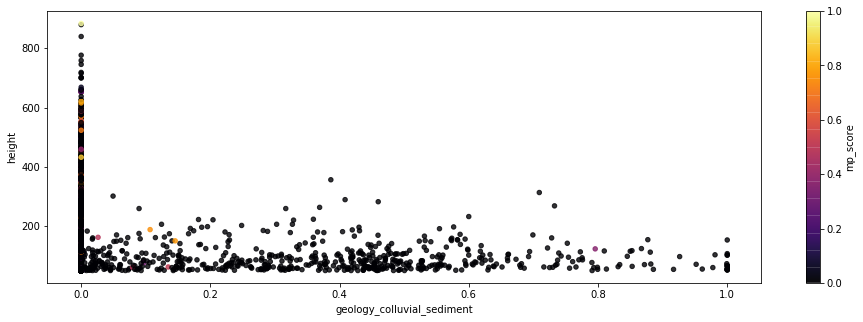

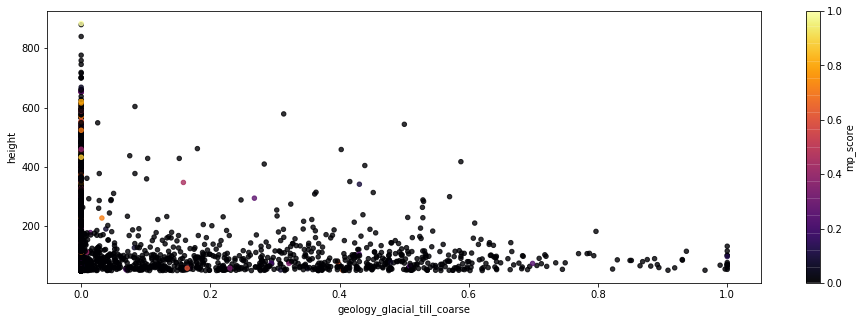

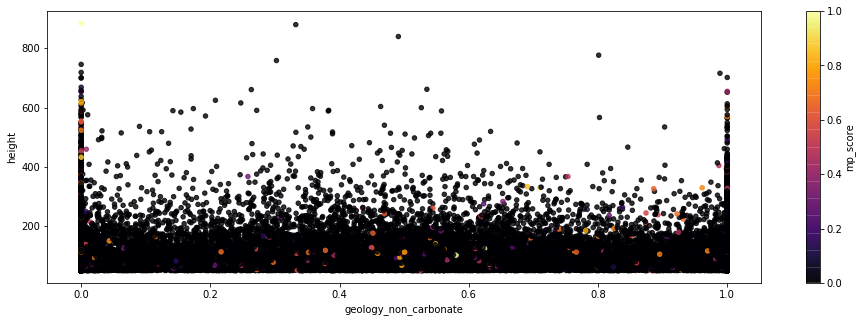

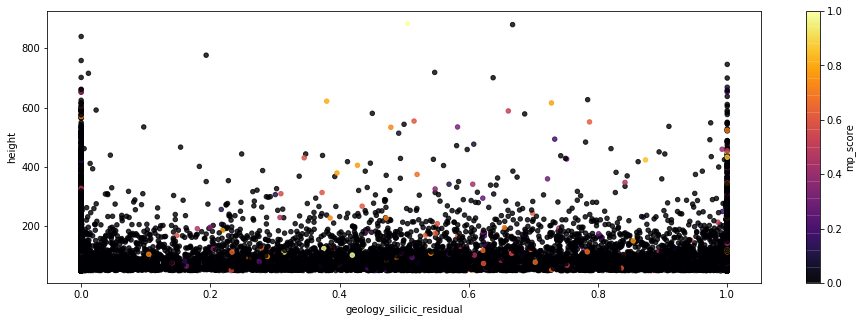

In [16]:
df['mp_score'] = (1000 * df.num_rock_routes + df.num_views).map(lambda x: 0 if x < 1000 else np.log2(x) / 10 - 1).clip(0, 1)


for label in ['B2', 'B4', 'B42', 'B5', 'B6', 'B65', 'B67', 'B7', 'geology_alluvium', 'geology_carbonate',
              'geology_colluvial_sediment', 'geology_glacial_till_coarse', 'geology_non_carbonate',
              'geology_silicic_residual']:
    fig = plt.figure(figsize=(16, 5))
    ax = fig.add_subplot(111)
    df.plot(x=label, y='height', kind='scatter', c='mp_score', alpha=0.8, colormap='inferno', ax=ax)
    plt.show()

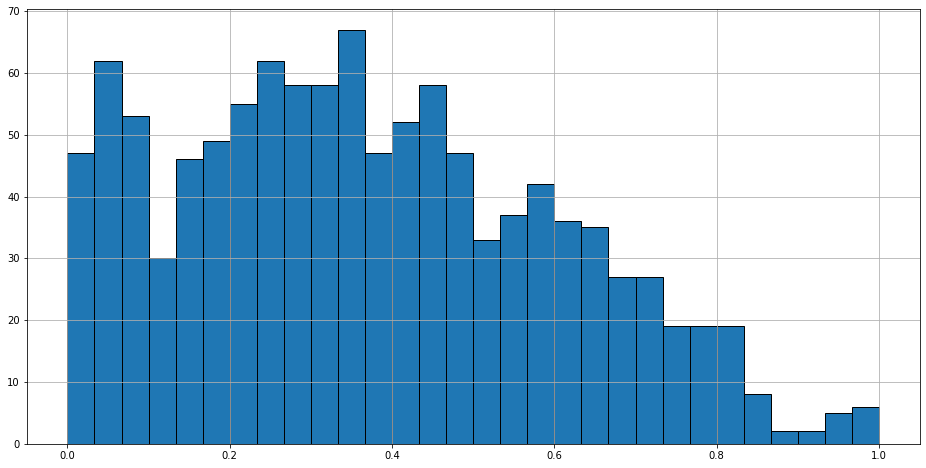

In [17]:
df.mp_score[df.mp_score > 0].hist(bins=30, edgecolor='black', linewidth=1.0);

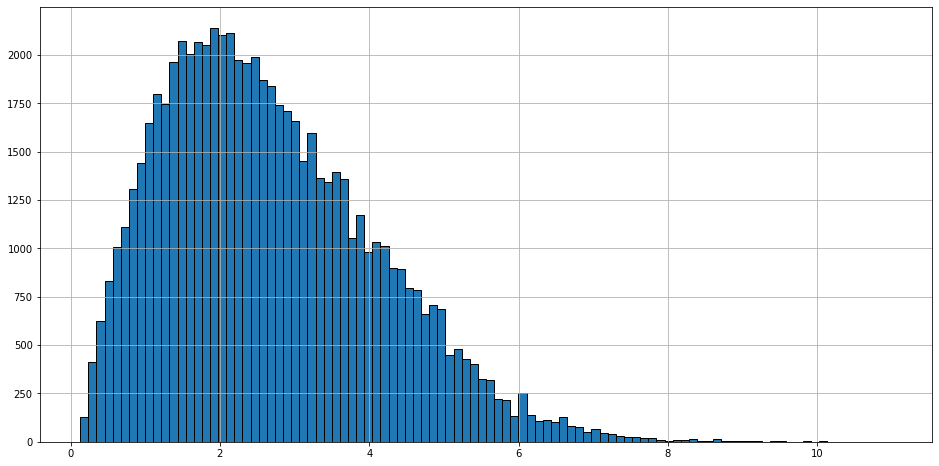

In [18]:
(df.height / df.pixel_count).hist(bins=100, edgecolor='black', linewidth=1.0);

Looking at crags with highest `mp_score`. El cap has a score of 1.0, as does some stuff in Eldo, Tahquitz, and Smith Rock.

In [19]:
df.sort_values(by='mp_score', ascending=False)[['mp_score', 'latitude', 'longitude', 'height', 'distance_to_mp']][:30]

,mp_score,latitude,longitude,height,distance_to_mp
63906,1.000000,39.931308,-105.285257,125,153.078
49130,1.000000,33.760540,-116.683779,85,136.498
72081,1.000000,39.931820,-105.286176,103,142.009
52768,1.000000,37.731722,-119.635903,884,49.1862
56504,0.982496,44.366024,-121.146607,74,26.1248
69648,0.969432,39.741315,-105.410240,76,156.896
72426,0.964086,38.547331,-109.599006,108,56.2307
25103,0.960709,36.035968,-115.468416,329,54.794
54570,0.960615,38.800348,-120.134458,156,118.26
55540,0.953903,43.742485,-110.803257,200,114.461
